In [3]:
from dotenv import load_dotenv
import os

load_dotenv()

if os.getenv("GROQ_API_KEY"):
    print('Groq API Key loaded successfully')
else:
    print('Groq API Key loading failed, please make sure the .env file exists and the spelling is correct')

if os.getenv("TAVILY_API_KEY"):
    print('Tavily API Key loaded successfully')
else:
    print('Tavily API Key loading failed, please make sure the .env file exists and the spelling is correct')

Groq API Key loaded successfully
Tavily API Key loaded successfully


In [4]:
from langchain_groq import ChatGroq
load_dotenv()

chat_model = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [5]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, BaseMessage
from langchain_groq import ChatGroq
import random
import copy
from typing import Any

In [6]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [6]:
#TODO: modellierung des games als eigene Klasse außerhalbs des agents inklusive Board, 
#modellierung des akt des Guessens als Custom Tool, welches auch Zugriff auf das Game-Objekt hat, 
#Frage ist nur wie das Tool zugriff darauf bekommt?
# Das Tool soll dann den guess akt + aufdecken processen und das Game updaten.


In [7]:
class Game:

    def __init__(self):
        self.board = self.initialize_board()
        self.red_words = [key for key, value in self.board.items() if value == "red"]
        self.blue_words = [key for key, value in self.board.items() if value == "blue"]
        self.black_words = [key for key, value in self.board.items() if value == "black"]
        self.has_turn = "RED"
        self.winner = None
        self.last_spymaster_answer = None
        self.rounds = 0
        self.guessed_words = set()

    def initialize_board(self):
        word_list = self.load_words()
        board_words = random.sample(word_list, 25)
        colors = ["red"] * 8 + ["blue"] * 8 + ["neutral"] * 7 + ["black"] * 2
        random.shuffle(colors)
        board = dict(zip(board_words, colors))
        return board
    
    def load_words(self):
        with open('wordlist-eng.txt', 'r') as file:
            words = [line.strip() for line in file]
            return words

In [8]:
from typing import Optional, Type

from langchain.callbacks.manager import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)
from langchain.pydantic_v1 import BaseModel, Field, PrivateAttr
from langchain.tools import BaseTool, StructuredTool, tool


class GuessInput(BaseModel):
    query: str = Field(description="should be a single word from the game-board")

class CustomGameTool(BaseTool):
    name: str = "custom_game_tool"
    description: str = "essential to guess words from the game-board"
    args_schema: Type[BaseModel] = GuessInput
    game: Game = PrivateAttr()

    def __init__(self, game):
        super().__init__()
        # Store the game object as an instance variable
        self.game = game

    def __call__(self, query: str) -> str:
        """Allows the tool to be callable directly."""
        return self._run(query)

    def _run(
        self, query: str, run_manager: Optional[CallbackManagerForToolRun] = None
    ) -> str:
        """Use the tool with context from the game object."""
        query = query.upper()
        if query in self.game.board.keys() and query not in self.game.guessed_words:
            self.game.guessed_words.add(query)
            return self.game.board[query]
        else:
            return f"WRONG: {query}"

    async def _arun(
        self, query: str, run_manager: Optional[AsyncCallbackManagerForToolRun] = None
    ) -> str:
        """Use the tool asynchronously with context from the game object."""
        raise NotImplementedError("custom_game_tool does not support async")

/home/jcaspary/anaconda3/envs/LLM/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [46]:
class Agent:
    
    def __init__(self, models: dict[str, dict[str, ChatGroq]], team_size=1, game=None, tools=None):
        self.game = game
        self.models = models
        self.team_size = team_size

        graph = StateGraph(AgentState)

        # Setting up the nodes for the state graph
        graph.add_node("spymaster_red", self.call_red_spymaster)
        graph.add_node("spymaster_blue", self.call_blue_spymaster)
        graph.add_node("teammember_red", self.call_red_guesser)
        graph.add_node("teammember_blue", self.call_blue_guesser)
        graph.add_node("teammember_red_2", self.call_red_guesser)
        graph.add_node("teammember_blue_2", self.call_blue_guesser)
        graph.add_node("action_red", self.take_action)
        graph.add_node("action_blue", self.take_action)

        # Conditional edges based on game state
        graph.add_conditional_edges(
             "action_blue",
             self.check_game_end,
             {True: END, False: "spymaster_red"}
        )
        graph.add_conditional_edges(
             "action_red",
             self.check_game_end,
             {True: END, False: "spymaster_blue"}
        )

        # Add edges for turn transitions
        graph.add_edge("spymaster_red", "teammember_red")
        #graph.add_edge("teammember_red", "action_red")
        graph.add_edge("spymaster_blue", "teammember_blue")
        #graph.add_edge("teammember_blue", "action_blue")
        graph.set_entry_point("spymaster_red")

        # Conditional edges that check for presence of guessing action otherwise invoke next team member
        graph.add_conditional_edges(
            "teammember_red",
            self.exists_guess,
            {True: "action_red", False: "teammember_red_2"}
        )
        graph.add_conditional_edges(
            "teammember_red_2",
            self.exists_guess,
            {True: "action_red", False: "teammember_red"}
        )
        graph.add_conditional_edges(
            "teammember_blue",
            self.exists_guess,
            {True: "action_blue", False: "teammember_blue_2"}
        )
        graph.add_conditional_edges(
            "teammember_blue_2",
            self.exists_guess,
            {True: "action_blue", False: "teammember_blue"}
        )
        
        # Compile graph to LangChain Runnable
        self.graph = graph.compile()
        
        # Bind tools to team member models if applicable
        self.tools = {t.name: t for t in tools}
        for name, model_dict in self.models.items():
            if "teammember" in name:
                model_dict["model"] = model_dict["model"].bind_tools(tools)


    def exists_guess(self, state: AgentState):
        result = state['messages'][-1]
        print(f"Test:{result}")
        return len(result.tool_calls) > 0
    
    # def exists_guess(self, state: AgentState):
    #     result = state['messages'][-1]
    #     # Check if the team member has made a deliberation before using the tool
    #     deliberation_message = "deliberated"
    #     deliberated = deliberation_message in result.content
    #     return len(result.tool_calls) > 0 and deliberated
            
    def call_red_spymaster(self, state: AgentState):
        return self._call_spymaster("RED", state)

    def call_blue_spymaster(self, state: AgentState):
        return self._call_spymaster("BLUE", state)

    def call_red_guesser(self, state: AgentState):
        number = random.randint(1,self.team_size)
        return self._call_guesser("RED", number, state)

    def call_blue_guesser(self, state: AgentState):
        number = random.randint(1,self.team_size)
        return self._call_guesser("BLUE", number, state)
    
    def check_game_end(self, state: AgentState):
        game_over = False
        if self.game.rounds > 5:
            game_over = True
        game_ends_black = any(word in self.game.guessed_words for word in self.game.black_words)
        game_ends_red = all(word in self.game.guessed_words for word in self.game.red_words)
        game_ends_blue = all(word in self.game.guessed_words for word in self.game.blue_words)
        if game_ends_black or game_ends_red or game_ends_blue:
            game_over = True
        if game_ends_black:
            self.game.winner = "BLUE" if self.game.has_turn == "RED" else "RED"
        elif game_ends_red:
            self.game.winner = "RED"
        elif game_ends_blue:
            self.game.winner = "BLUE"
        
        if game_over:
            print(f"guessed_words: {', '.join(self.game.guessed_words)}")
            print(f"WINNER: {self.game.winner}")
            print(f"ROUNDS PLAYED: {self.game.rounds}")
            return True
        return False
    
    def take_action(self, state: AgentState):
        tool_calls = state.get('messages', [])[-1].tool_calls
        results = []
        guesses = 0
        for t in tool_calls:
            if t['name'] in self.tools:
                result = self.tools[t['name']].invoke(t['args'])
                guesses += 1
            else:
                result = "Invalid tool name, retry"
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
            if guesses >= 1:  # Guess limit
                break
        return {'messages': results}
    
    def _call_spymaster(self, team, state):
        self.game.rounds += 1
        round = self.game.rounds
        messages = state['messages']
        prompt = self.get_spymaster_prompt(team)
        model = self.models[f"spymaster_{team}"]["model"]
        message = model.invoke(prompt)
        message.id = f"{round}_spymaster_{team}"
        #state['messages'].append(message)
        self.game.last_spymaster_answer = message
        return {'messages': [message]}
    
    def _call_guesser(self, team, number, state):
        round = self.game.rounds
        messages = state['messages']
        prompt = self.get_guesser_prompt(team, number)[0].content
        
        # Retrieve spymaster's hint and prepare discussion string
        spymaster_message = self.get_message_by_id(messages, f"{round}_spymaster_{team}")
        spymaster_hint = f"Spymaster's hint: {spymaster_message if spymaster_message else 'No hint available'} \n"
        filtered_messages = [m for m in messages if m.id is not None and m.id.startswith(f"{round}_teammember_{team}")]
        current_discussion_string = "\n".join(f"{m.id[2:]}: {m.content}" for m in filtered_messages if m.id is not None)
        if current_discussion_string == "":
            current_discussion_string = "No discussion has taken place yet."
        
        # Combine into new_prompt
        new_prompt_content = (
            prompt
            + "\n"
            + spymaster_hint
            + f"\nThis is the current discussion with your Teammates (you are teammember_{team}_{number}):"
            + "\n"
            + current_discussion_string
        )
        model = self.models[f"teammember_{team}_{number}"]["model"]
        message = model.invoke([new_prompt_content])  # Pass as a single-item list containing the BaseMessage instance
        
        # Set message ID and append
        message.id = f"{round}_teammember_{team}_{number}"
        #state['messages'].append(message)
        print(f"GuessID: {round}_teammember_{team}_{number}")
        print(f"Prompt: \n {new_prompt_content}")
        print(f"Answer: \n {message.content}")  # Display prompt content for verification
        
        return {'messages': [message]}
        
    def get_spymaster_prompt(self, team):
        not_guessed_board = {k: v for k, v in self.game.board.items() if k not in self.game.guessed_words}
        relevant_words = [k for k, v in not_guessed_board.items() if v.lower() == team.lower()]
        bad_words = [k for k, v in not_guessed_board.items() if v.lower() != team.lower()]
        
        return [SystemMessage(content=self.models[f"spymaster_{team}"]["system"]
            + f"\nGood words: {', '.join(relevant_words)}\n"
            + f"Bad words: {', '.join(bad_words)}"
        )]
    
    def get_guesser_prompt(self, team, number):
        not_guessed_board = [k for k in self.game.board if k not in self.game.guessed_words]
        hint_word = self.game.last_spymaster_answer

        return [SystemMessage(content=self.models[f"teammember_{team}_{number}"]["system"]
            + f"\nWord list: {', '.join(not_guessed_board)}\n"
            + f"Hint word: {hint_word}"
        )]
    
    def get_message_by_id(self, messages, target_id):
        for message in messages:
            if message.id == target_id:
                return message.content
        return None  # Return None if no message with the given id is found

In [51]:
spymaster_system_prompt = """
You are playing the game Codenames as the spymaster. Your role is to help your teammates guess specific target words (the "good words") by giving a single-word hint each round.

1. Your hint should relate to the "good words" and be as descriptive as possible without revealing the "bad words."
2. Only respond with **one word** and **one number**. The word represents the hint, and the number indicates the number of target words that relate to the hint.
3. Avoid hints that could describe the bad words in any way, as this would mislead your teammates.

Remember, your teammates do not know which words are good or bad—they rely on your hint to identify the good words.

VERY IMPORTANT: Just give the single word hint, do NOT describe your reasoning as that would ruin the game! 

"""

teammember_system_prompt = """
    You are a team member in the game Codenames. Each round, your spymaster will give a one-word hint and a number. Your goal is to guess the target words based on this hint.

    1. Use the hint word to find words that semantically relate to the target, based on the spymaster’s clue.
    2. The number indicates how many words the hint likely applies to. Keep this in mind while choosing words.
    3. Discuss and collaborate with me and the other team members to reach a consensus before making each guess.
    4. Do NOT take use the guessing tool if you have not yet deliberated with everyone else.
    5. If you do not use the guessing tool, reason shortly and precisely so your team can benefit from your insights.
    6. Use the provided guessing tool to submit each guess. If correct, you may guess again until the number limit is reached or an incorrect guess is made.

    Each guess brings your team closer to victory, but beware—incorrect guesses may help the opposing team! And don't forget: be social and deliberate!
"""

teammember_system_prompt = """
    You are a team member in the game Codenames. Each round, your spymaster will give a one-word hint and a number. Your goal is to guess the target words based on this hint.

    1. Use the hint word to find words that semantically relate to the target, based on the spymaster’s clue.
    2. The number indicates how many words the hint likely applies to. Keep this in mind while choosing words.
    3. Discuss and collaborate with your teammates to reach a consensus before making each guess.
    4. If you have not yet deliberated, DO NOT use the guessing tool. You must first communicate with your teammates that you are ready to make a guess.
    5. Do not deliberate based solely on your own statements during the discussion. Check if others already spoke during the discussion.
    5. Type "I have deliberated with my team" once you are ready to make your guess, signaling that your deliberation is complete.
    6. If you do not use the guessing tool, reason shortly and precisely so your team can benefit from your insights.
    7. Use the provided guessing tool to submit each guess. If correct, you may guess again until the number limit is reached or an incorrect guess is made.

    Each guess brings your team closer to victory, but beware—incorrect guesses may help the opposing team!
"""

models = {
    "spymaster_RED": {"model": None, "system": spymaster_system_prompt},
    "spymaster_BLUE": {"model": None, "system": spymaster_system_prompt},
    "teammember_RED_1": {"model": None, "system": teammember_system_prompt},
    "teammember_BLUE_1": {"model": None, "system": teammember_system_prompt},
    "teammember_RED_2": {"model": None, "system": teammember_system_prompt},
    "teammember_BLUE_2": {"model": None, "system": teammember_system_prompt},
}

for name, model_dict in models.items():
    if "spymaster" in name:
        model_dict["model"] = ChatGroq(
        model="llama-3.1-70b-versatile",
        temperature=0,
        max_tokens=20,
        timeout=None,
        max_retries=2,
        )   
    else:
        model_dict["model"] = ChatGroq(
        model="llama-3.1-70b-versatile",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
        )

# pass the LLM, the tool (only one here) and the system prompt
game = Game()  
tools = CustomGameTool(game)
abot = Agent(models, team_size=2, game=game, tools=[tools])

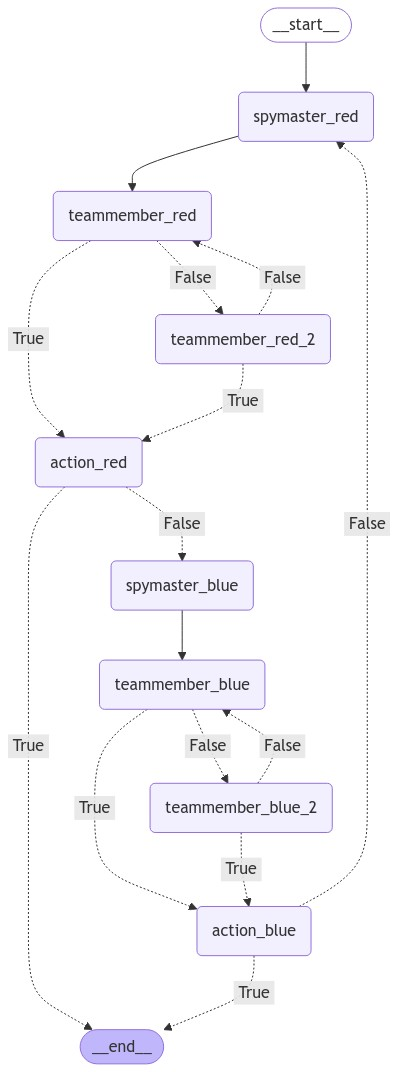

In [44]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        abot.graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [52]:
messages = [HumanMessage(content="Play a game of Codenames.")]
result = abot.graph.invoke({"messages": messages})

GuessID: 1_teammember_RED_2
Prompt: 
 
    You are a team member in the game Codenames. Each round, your spymaster will give a one-word hint and a number. Your goal is to guess the target words based on this hint.

    1. Use the hint word to find words that semantically relate to the target, based on the spymaster’s clue.
    2. The number indicates how many words the hint likely applies to. Keep this in mind while choosing words.
    3. Discuss and collaborate with your teammates to reach a consensus before making each guess.
    4. If you have not yet deliberated, DO NOT use the guessing tool. You must first communicate with your teammates that you are ready to make a guess.
    5. Do not deliberate based solely on your own statements during the discussion. Check if others already spoke during the discussion.
    5. Type "I have deliberated with my team" once you are ready to make your guess, signaling that your deliberation is complete.
    6. If you do not use the guessing tool, r

KeyboardInterrupt: 

In [25]:
result

{'messages': [HumanMessage(content='Play a game of Codenames.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='HAND 2', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 294, 'total_tokens': 298, 'completion_time': 0.016, 'prompt_time': 0.060101205, 'queue_time': 0.067171595, 'total_time': 0.076101205}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_5c5d1b5cfb', 'finish_reason': 'stop', 'logprobs': None}, id='1_spymaster_RED', usage_metadata={'input_tokens': 294, 'output_tokens': 4, 'total_tokens': 298}),
  AIMessage(content='HAND 2', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 294, 'total_tokens': 298, 'completion_time': 0.016, 'prompt_time': 0.060101205, 'queue_time': 0.067171595, 'total_time': 0.076101205}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_5c5d1b5cfb', 'finish_reason': 'stop', 'logprobs': None}, id='1_spymaster